In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from textblob import TextBlob
%matplotlib inline
import re
from nltk.corpus import stopwords
from spacy.en import English
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
from spacy.en import STOP_WORDS
nlp = English()
stop = set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [2]:
budget = pd.read_csv('./school_budget_train.csv')

In [3]:
budget_df = pd.DataFrame(budget)

budget_df.head()

,Unnamed: 0,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
0,134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
1,206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
2,326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
3,364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
4,47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [4]:
budget_df.columns = ['ID' if x=='Unnamed: 0' else x for x in budget_df.columns]

In [5]:
budget_df.shape

(400277, 26)

In [6]:
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 26 columns):
ID                        400277 non-null int64
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    179964 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE        

In [7]:
targets = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type',
       'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']

In [8]:
predictors = [col for col in budget_df.columns if col not in targets]
word_predictors = ['Object_Description','Text_2','SubFund_Description','Job_Title_Description','Text_3',
                    'Text_4','Sub_Object_Description','Location_Description','Function_Description',
                    'Facility_or_Department','Position_Extra','Program_Description','Fund_Description','Text_1']
num_predictors= ['Total', 'FTE']

### Change label columns, append category names to labels

In [9]:
for col in budget_df[targets]:
    budget_df[col] = str(col)+'__'+ budget_df[col].astype(str)

In [10]:
budget_df[targets].head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
0,Function__Teacher Compensation,Use__Instruction,Sharing__School Reported,Reporting__School,Student_Type__NO_LABEL,Position_Type__Teacher,Object_Type__NO_LABEL,Pre_K__NO_LABEL,Operating_Status__PreK-12 Operating
1,Function__NO_LABEL,Use__NO_LABEL,Sharing__NO_LABEL,Reporting__NO_LABEL,Student_Type__NO_LABEL,Position_Type__NO_LABEL,Object_Type__NO_LABEL,Pre_K__NO_LABEL,Operating_Status__Non-Operating
2,Function__Teacher Compensation,Use__Instruction,Sharing__School Reported,Reporting__School,Student_Type__Unspecified,Position_Type__Teacher,Object_Type__Base Salary/Compensation,Pre_K__Non PreK,Operating_Status__PreK-12 Operating
3,Function__Substitute Compensation,Use__Instruction,Sharing__School Reported,Reporting__School,Student_Type__Unspecified,Position_Type__Substitute,Object_Type__Benefits,Pre_K__NO_LABEL,Operating_Status__PreK-12 Operating
4,Function__Substitute Compensation,Use__Instruction,Sharing__School Reported,Reporting__School,Student_Type__Unspecified,Position_Type__Teacher,Object_Type__Substitute Compensation,Pre_K__NO_LABEL,Operating_Status__PreK-12 Operating


In [11]:
categorize_label = lambda x: x.astype('category')
budget_df[targets] = budget_df[targets].apply(categorize_label, axis=0)

In [12]:
budget_df.dtypes

ID                           int64
Function                  category
Use                       category
Sharing                   category
Reporting                 category
Student_Type              category
Position_Type             category
Object_Type               category
Pre_K                     category
Operating_Status          category
Object_Description          object
Text_2                      object
SubFund_Description         object
Job_Title_Description       object
Text_3                      object
Text_4                      object
Sub_Object_Description      object
Location_Description        object
FTE                        float64
Function_Description        object
Facility_or_Department      object
Position_Extra              object
Total                      float64
Program_Description         object
Fund_Description            object
Text_1                      object
dtype: object

### Fill NaN values with empty strings

In [13]:
budget_df[predictors].isnull().sum().sort_values()

ID                             0
Total                       4555
Object_Description         24784
Function_Description       58082
SubFund_Description        93422
Program_Description        95617
Job_Title_Description     107534
Text_1                    107992
Position_Extra            135513
Fund_Description          197400
Text_3                    220313
Location_Description      238223
FTE                       274206
Sub_Object_Description    308674
Text_2                    312060
Facility_or_Department    346391
Text_4                    346531
dtype: int64

In [14]:
for col in budget_df[word_predictors]:
    budget_df[col] = budget_df.loc[:,[col]].fillna(' ')

In [15]:
budget_df[predictors].isnull().sum()

ID                             0
Object_Description             0
Text_2                         0
SubFund_Description            0
Job_Title_Description          0
Text_3                         0
Text_4                         0
Sub_Object_Description         0
Location_Description           0
FTE                       274206
Function_Description           0
Facility_or_Department         0
Position_Extra                 0
Total                       4555
Program_Description            0
Fund_Description               0
Text_1                         0
dtype: int64

In [16]:
budget_df.describe()

,ID,FTE,Total
count,400277.000000,126071.000000,3.957220e+05
mean,225186.018537,0.426794,1.310586e+04
std,130025.142718,0.573576,3.682254e+05
min,2.000000,-0.087551,-8.746631e+07
25%,112601.000000,0.000792,7.379770e+01
50%,225243.000000,0.130927,4.612300e+02
75%,337722.000000,1.000000,3.652662e+03
max,450340.000000,46.800000,1.297000e+08


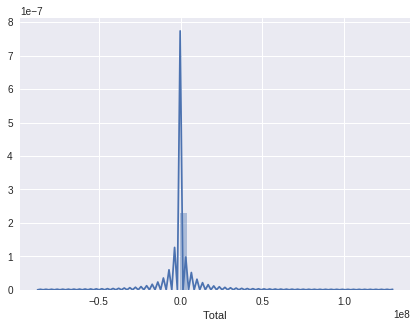

In [17]:
plt.figure(1, figsize=(7,5))
_ = sns.distplot(budget_df['Total'].dropna())

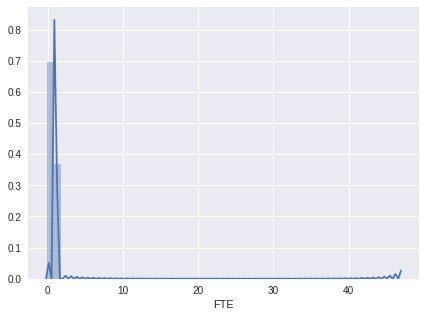

In [18]:
plt.figure(1, figsize=(7,5))
_ = sns.distplot(budget_df['FTE'].dropna())

## Figure out what to do with NaN values for numerical columns

## Data processesing with word predictor columns

In [19]:
for col in budget_df[word_predictors]:
    budget_df[col] = budget_df[col].str.lower()

In [20]:
budget_df[word_predictors].head(20)

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1
0,,,,teacher-elementary,,,,,,,kindergarten,kindergarten,general fund,
1,contractor services,bond expenditures,building fund,(blank),regular,,,,rgn gob,,undesignated,building improvement services,,building improvement services
2,personal services - teachers,,,tcher 2nd grade,,regular instruction,,,,,teacher,instruction - regular,general purpose school,
3,employee benefits,teacher subs,general fund,"teacher, short term sub",regular,,,,unalloc budgets/schools,,professional-instructional,general middle/junior high sch,,regular instruction
4,teacher coverage for teacher,teacher subs,general fund,"teacher, secondary (high)",alternative,,,,non-project,,professional-instructional,general high school education,,regular instruction
5,contra benefits,,general fund,custodian - pt - jobs,n/a,,,,non-project,,undesignated,employee benefits,,employee benefits
6,educational,special education instruction,local,,,,,,,,supplies and materials,special education local,local fund,
7,employee benefits,,general fund,"sub manager, food service",n/a,,,district wide organization uni,non-project,,undesignated,undesignated,,undesignated
8,employee benefits,,general fund,"teacher, elementary",regular,,,,ela s - teaching spanish only,,professional-instructional,general elementary education,,regular instruction
9,employee benefits,teacher subs,general fund,"teacher,retrd shrt term sub",regular,,,,unalloc budgets/schools,,professional-instructional,general elementary education,,regular instruction


In [26]:
def cleaner(text):
    text = re.sub('[\W]',' ',text)
    text = re.sub("\\s+", " ", text)
    return text
    

In [29]:
for col in budget_df[word_predictors]:
    budget_df[col] = budget_df[col].apply(cleaner)

In [31]:
budget_df[word_predictors].head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,Function_Description,Facility_or_Department,Position_Extra,Program_Description,Fund_Description,Text_1
0,,,,teacher elementary,,,,,,,kindergarten,kindergarten,general fund,
1,contractor services,bond expenditures,building fund,blank,regular,,,,rgn gob,,undesignated,building improvement services,,building improvement services
2,personal services teachers,,,tcher 2nd grade,,regular instruction,,,,,teacher,instruction regular,general purpose school,
3,employee benefits,teacher subs,general fund,teacher short term sub,regular,,,,unalloc budgets schools,,professional instructional,general middle junior high sch,,regular instruction
4,teacher coverage for teacher,teacher subs,general fund,teacher secondary high,alternative,,,,non project,,professional instructional,general high school education,,regular instruction


## Use TFIDF to vectorize words

In [22]:
from nltk.corpus import stopwords
from spacy.en import English
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
from spacy.en import STOP_WORDS
nlp = English()
stop = set(stopwords.words('english'))

In [19]:
def create_tfidf(word_column):
    tfidf = TfidfVectorizer(stop_words='english', min_df=100)
    col_matrix = tfidf.fit_transform(budget_df[word_column])
    
    col_matrix_df = pd.DataFrame(col_matrix.toarray(),
                                       index=budget_df.index,
                                       columns=tfidf.get_feature_names())
    return col_matrix_df